In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import hdbscan

import io
import os
import zipfile
import requests
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Make new directory for extracting .tif file and read file using requests
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'
output_dir = "/Users/nareshdhami/Desktop/Visual Code/Coursera_ML/"
os.makedirs(output_dir, exist_ok=True)
response = requests.get(url)
response.raise_for_status()

In [4]:
# Extract zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    for f_name in zip_ref.namelist():
        if f_name.endswith('.tif'):
            zip_ref.extract(f_name, output_dir)
            print(f'Zip file {f_name} is extracted to {output_dir}')

Zip file Canada.tif is extracted to /Users/nareshdhami/Desktop/Visual Code/Coursera_ML/


In [5]:
# Create function for plotting
def plot_clustered_locations(df, title='Museums Clustered by Proximity'):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(15, 10))
    no_noise = gdf[gdf['Cluster']!=-1]
    noise = gdf[gdf['Cluster']==-1]

    noise.plot(ax=ax, color='red', ec='k', label='Noise Data', alpha=0.8, markersize=30)
    no_noise.plot(ax=ax, cmap='magma', column='Cluster', label='No-Noise Data', alpha=0.8, markersize=30)   #cmpa will use column='Cluster' as color coding
    ctx.add_basemap(ax=ax, zoom=6)
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='best')
    # plt.tight_layout()
    plt.show()

In [6]:
# Create DataFrame from csv file
url_ = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url_, encoding='ISO-8859-1')
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


In [8]:
# Separating Latitude and Longitude column 
df = df[['Latitude', 'Longitude']]

# Create a function that checks if value in single row for both Latitude and Longitude are valid numbers
def is_valid_number(value):
    try:
        float(value) or int(value)
        return True
    except:
        return False
df = df[df['Latitude'].apply(is_valid_number) & df['Longitude'].apply(is_valid_number)]
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype(float)

****DBSCAN****

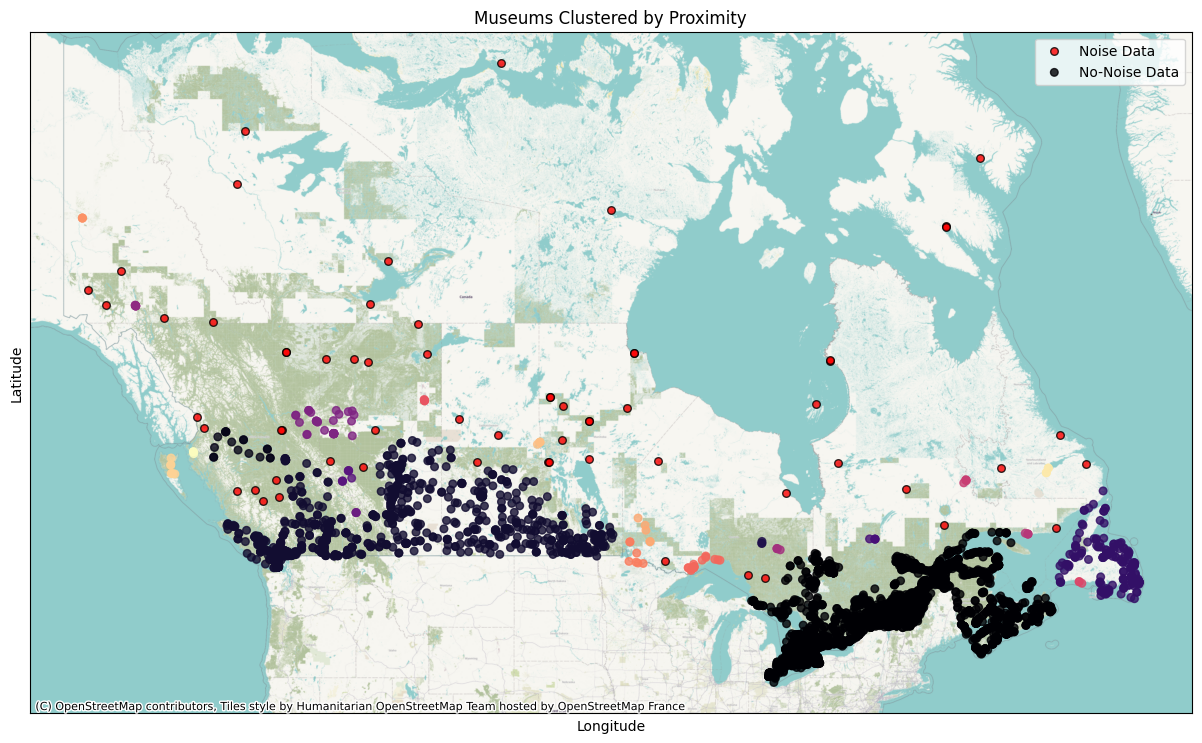

In [9]:
model = DBSCAN(eps=1.0, 
               min_samples=3,
               metric='euclidean')
model.fit(df)
labels = model.fit_predict(df)
df['Cluster'] = labels
plot_clustered_locations(df, title='Museums Clustered by Proximity')

****HDBSCAN****

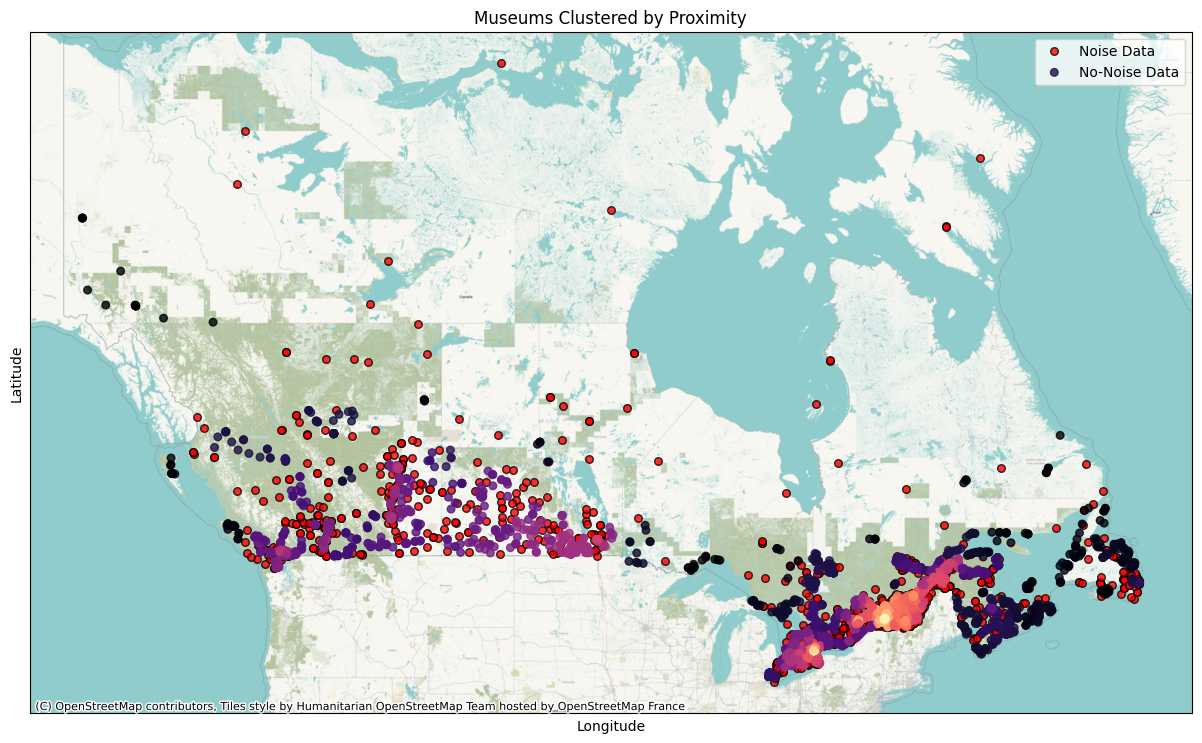

In [10]:
df_hdb = df.drop(columns='Cluster')
model_hdb = hdbscan.HDBSCAN(min_cluster_size=3, 
                            min_samples=3, 
                            metric='euclidean')
model_hdb.fit(df_hdb)
df_hdb['Cluster'] = model_hdb.fit_predict(df_hdb)

plot_clustered_locations(df_hdb, title='Museums Clustered by Proximity')